# Set-up

## Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 200
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score, classification_report, matthews_corrcoef, PrecisionRecallDisplay
import joblib

## Parameters

In [22]:
scope = 'OFF'

input_path = f'../data/3_output/ML_dataset_{scope}.pkl'

start_month = 201901
end_month = 202212

subsample_size = None

target = 'Result'

## Functions

In [23]:
def APS(groupby, prob_col_name='y_probs'):
    non_nan_mask = ~groupby[[target, prob_col_name]].isna().any(axis=1)
    # if (~groupby[prob_col_name].isna()).sum() == 0:
    #     return np.nan
    if non_nan_mask.sum() == 0:
        return np.nan
    else:
        # return average_precision_score(groupby[target], groupby[prob_col_name])
        return average_precision_score(groupby.loc[non_nan_mask, target], groupby.loc[non_nan_mask, prob_col_name])

In [24]:
def get_APS_per_model(df, group_col, models, plot=True, plot_kind='bar', **kwargs):
    group_df = df.groupby(group_col)
    aps_df = pd.DataFrame()
    for model in models:
        aps_df[model] = group_df.apply(lambda group: APS(group, prob_col_name=f'y_{model}')).rename({None: f'APS_{model}'})
    aps_df.index = aps_df.index.astype(str)
    if plot:
        aps_df.plot(kind=plot_kind, **kwargs)
        plt.xlabel(group_col)
        plt.xticks(rotation=0)
        plt.ylabel('Average Precision Score (APS)')
        plt.ylim((0,1))
        plt.title('Models performance for {} bids per {}'.format(scope, group_col))
        plt.savefig('../plots/{}/models_comparison/{}_aps_{}_{}.png'.format(scope, '_'.join(models), group_col, scope.lower()))
        plt.show()
    return aps_df

# Main

## Load dataset

In [25]:
# Load dataset
input_df = pd.read_pickle(input_path)
df = input_df.copy()
# Select only observations for which we generated a prediction
df['yearmonth'] = df.index.str[:6].astype(int)
df['month'] = df.index.str[4:6].astype(int)
df = df[(df.yearmonth >= start_month) & (df.yearmonth <= end_month)]
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,yearmonth,month
201901011UP_ACTV_1_OFF,1,20190101,2019,UP_ACTV_1,OFF,1.987508,-0.446966,-2.921364,-0.137306,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.436,False,201901,1
201901012UP_ACTV_1_OFF,2,20190101,2019,UP_ACTV_1,OFF,2.992812,0.367096,-3.134924,0.025819,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.475,False,201901,1
201901013UP_ACTV_1_OFF,3,20190101,2019,UP_ACTV_1,OFF,5.121951,-2.372232,-3.379947,0.027554,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.531,False,201901,1
201901014UP_ACTV_1_OFF,4,20190101,2019,UP_ACTV_1,OFF,3.023857,-0.063917,-3.585943,-0.011441,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.647,False,201901,1
201901015UP_ACTV_1_OFF,5,20190101,2019,UP_ACTV_1,OFF,3.785303,2.527202,-3.723609,0.051985,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.711,False,201901,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_OFF,17,20221231,2022,UP_VOGHERA_1,OFF,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,holiday,Pavia,Fossil Gas,0.540,0.540,320.0,0.066,False,202212,12
2022123121UP_VOGHERA_1_OFF,21,20221231,2022,UP_VOGHERA_1,OFF,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,holiday,Pavia,Fossil Gas,0.573,0.573,320.0,0.016,False,202212,12
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF,2.244316,-3.847872,-2.345759,0.833482,-2.547642,...,holiday,Pavia,Fossil Gas,0.526,0.526,320.0,0.085,False,202212,12
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,holiday,Pavia,Fossil Gas,0.525,0.525,320.0,0.190,False,202212,12


## Load predictions

### RF

In [27]:
years = [2018, 2019, 2020, 2021, 2022]
for year in years[:-1]:
    test_years = '_'.join([str(y) for y in years if y > year])
    df[f'y_RF{year}'] = pd.read_pickle(f'{scope}/model_predictions/RF_predicted_probs_train_{year}_test_{test_years}.pkl')

### RF monthly recal 12 months

In [28]:
df['y_RFrecal'] = pd.read_pickle(f'{scope}/model_predictions/RF_predicted_probs_monthly_recal_rolling_12m.pkl')

### GLM monthly recal 12 months

In [29]:
df['y_GLMrecal'] = pd.read_csv(f'{scope}/model_predictions/GLM_predicted_probs_monthly_recal_rolling_12m.csv', index_col=0)['y_probs']

### HP monthly recal 12 months

In [30]:
df['y_HPrecal'] = pd.read_pickle(f'{scope}/model_predictions/HP_predicted_probs_monthly_recal_rolling_12m.pkl')

### Random classifier

In [31]:
df['y_random'] = df.Result.sum() / len(df)

In [32]:
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,yearmonth,month,y_RF2018,y_RF2019,y_RF2020,y_RF2021,y_RFrecal,y_GLMrecal,y_HPrecal,y_random
201901011UP_ACTV_1_OFF,1,20190101,2019,UP_ACTV_1,OFF,1.987508,-0.446966,-2.921364,-0.137306,-0.401592,...,201901,1,0.00,NaN,NaN,NaN,0.00,0.000874,0.020582,0.034471
201901012UP_ACTV_1_OFF,2,20190101,2019,UP_ACTV_1,OFF,2.992812,0.367096,-3.134924,0.025819,-0.401592,...,201901,1,0.00,NaN,NaN,NaN,0.00,0.000848,0.014158,0.034471
201901013UP_ACTV_1_OFF,3,20190101,2019,UP_ACTV_1,OFF,5.121951,-2.372232,-3.379947,0.027554,-0.401592,...,201901,1,0.00,NaN,NaN,NaN,0.00,0.000850,0.012246,0.034471
201901014UP_ACTV_1_OFF,4,20190101,2019,UP_ACTV_1,OFF,3.023857,-0.063917,-3.585943,-0.011441,-0.401592,...,201901,1,0.00,NaN,NaN,NaN,0.00,0.000464,0.006654,0.034471
201901015UP_ACTV_1_OFF,5,20190101,2019,UP_ACTV_1,OFF,3.785303,2.527202,-3.723609,0.051985,-0.401592,...,201901,1,0.00,NaN,NaN,NaN,0.00,0.000474,0.005512,0.034471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_OFF,17,20221231,2022,UP_VOGHERA_1,OFF,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,202212,12,0.20,0.17,0.28,0.39,0.41,0.086867,0.098319,0.034471
2022123121UP_VOGHERA_1_OFF,21,20221231,2022,UP_VOGHERA_1,OFF,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,202212,12,0.11,0.13,0.23,0.32,0.43,0.142524,0.086938,0.034471
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF,2.244316,-3.847872,-2.345759,0.833482,-2.547642,...,202212,12,0.27,0.20,0.34,0.41,0.45,0.132044,0.062058,0.034471
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,202212,12,0.35,0.29,0.34,0.32,0.56,0.105553,0.048416,0.034471


## Compare performances

### RF years vs Monthly Recal

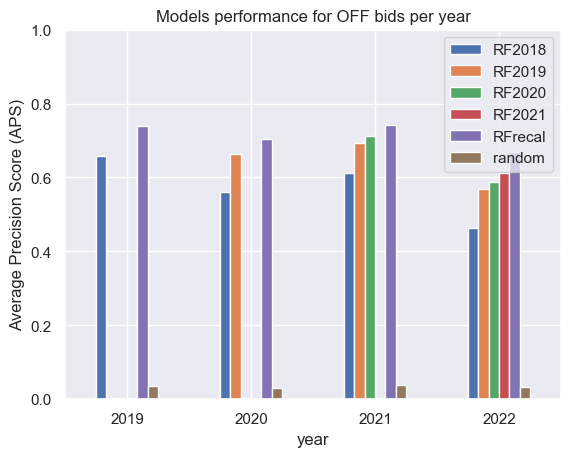

,RF2018,RF2019,RF2020,RF2021,RFrecal,random
year,,,,,,
2019,0.658176,NaN,NaN,NaN,0.739510,0.035759
2020,0.559458,0.662507,NaN,NaN,0.703655,0.030636
2021,0.613198,0.694357,0.712377,NaN,0.740727,0.037618
2022,0.462135,0.569613,0.588875,0.611818,0.668945,0.033855


In [33]:
models = ['RF2018', 'RF2019', 'RF2020', 'RF2021', 'RFrecal', 'random']
get_APS_per_model(df, 'year', models)

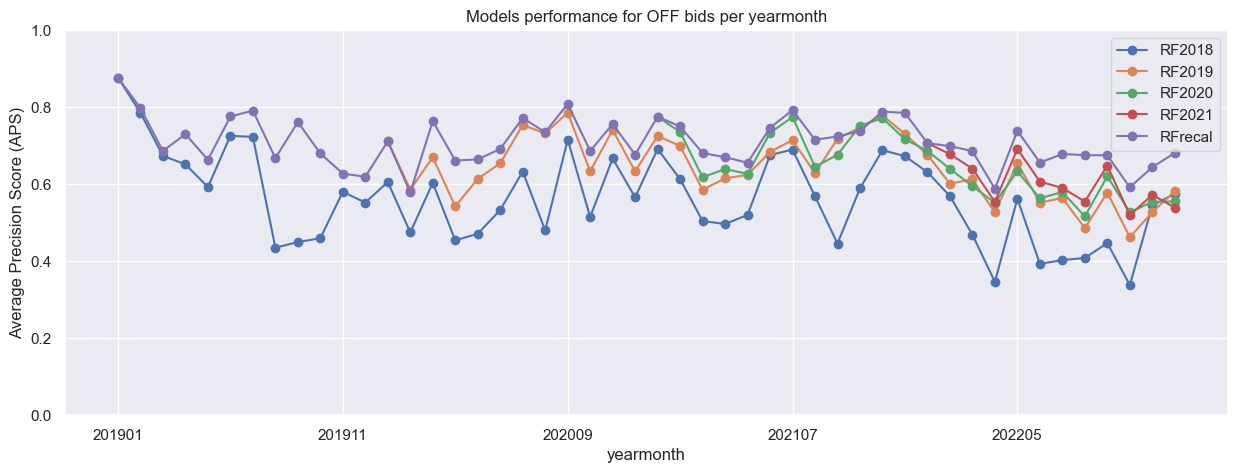

In [34]:
models = ['RF2018', 'RF2019', 'RF2020', 'RF2021', 'RFrecal']
aps_df = get_APS_per_model(df, 'yearmonth', models, plot_kind='line', figsize=(15,5), marker='o')

### RF vs others

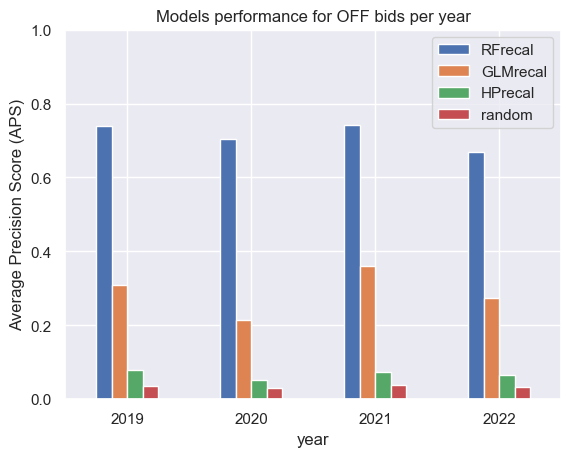

,RFrecal,GLMrecal,HPrecal,random
year,,,,
2019,0.739510,0.307789,0.079529,0.035759
2020,0.703655,0.213809,0.052772,0.030636
2021,0.740727,0.361761,0.073092,0.037618
2022,0.668945,0.274767,0.066046,0.033855


In [35]:
models = ['RFrecal', 'GLMrecal', 'HPrecal', 'random']
get_APS_per_model(df, 'year', models)

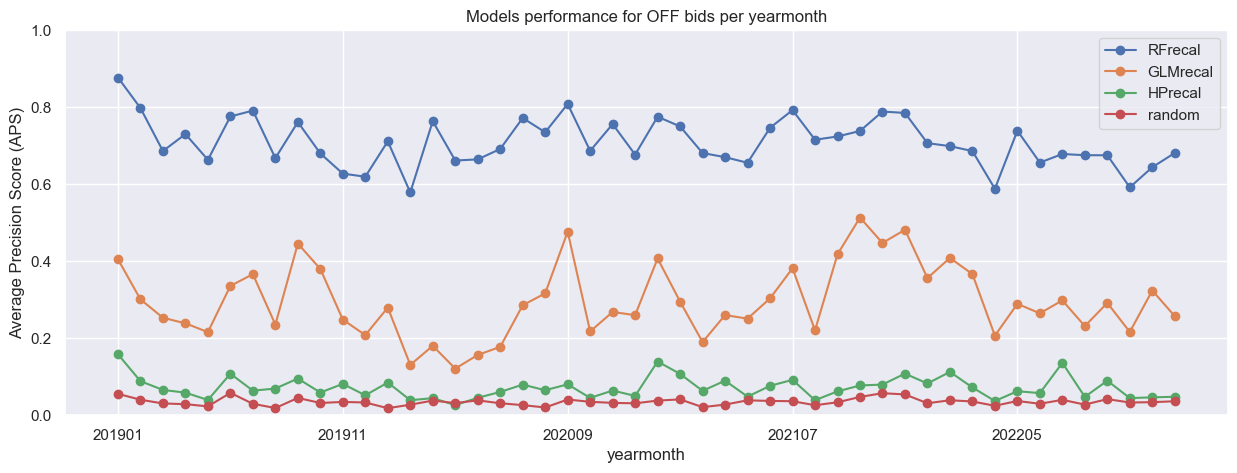

In [36]:
aps_df = get_APS_per_model(df, 'yearmonth', models, plot_kind='line', figsize=(15,5), marker='o')